<a href="https://colab.research.google.com/github/swilsonmfc/notebooks/blob/master/VariationalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Auto Encoder

![](https://keitakurita.files.wordpress.com/2017/12/autoencoder1.png?resize=840%2C284)

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import random
import math

from scipy.stats import norm

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow_probability as tfp

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Layer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from ipywidgets import interact

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([X_train, X_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
mnist_labels = np.concatenate([y_train, y_test])
mnist_labels = to_categorical(mnist_labels)

print(mnist_digits.shape)
print(mnist_labels.shape)

11493376/11490434 [==============================] - 0s 0us/step
(70000, 28, 28, 1)
(70000, 10)


In [3]:
INPUT_SHAPE = (28, 28, 1)

# AutoEncoders
* Create an information bottleneck
* Force a neural network to learn a low-level representation of the data
  * Neural networks learn this in a non-linear way
  * In contrast, PCA uses linear transformations
* Comprised of 
  * An encoder (which builds the low level representation)
  * A decoder (that takes a low level representation and regenerates the original data) 
  * Loss function that minimizes reconstruction error
* Useful for:
  * Learning "normal" - outliers
  * Denoising data
  * Compression

![](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)

# VAE
* What if our goal changes slightly?
  * Rather than compression / denoising  
  * We want to generate new images
* Autoencoder
  * We know the bottleneck is a compressed / low dimension representation
  * We know the decode can reconstruct from that representation
  * But, if we wanted a new image, what would we pass the decoder?
  * In other words, what does the latent space look like?
* Variation AutoEncoder 
  * Is a particular type of auto encoder 
  * Learns to fit its low level representation in a distribution
  * Encoder maps to this distribution
  * Decoder learns to recreate an image from that distribution
  * Therefore, We can draw from the distribution to draw new examples
* VAE is a great example of generative deep learning!

In [4]:
LATENT_DIM  = 2

## Encoder

In [5]:
class Sampling(Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
def build_encoder(latent_dims=LATENT_DIM):
  encoder_inputs = keras.Input(shape=(28, 28, 1))
  x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
  x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  x = Flatten()(x)
  x = Dense(16, activation="relu")(x)
  z_mean = Dense(latent_dims, name="z_mean")(x)
  z_log_var = Dense(latent_dims, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
  return encoder

encoder = build_encoder()
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

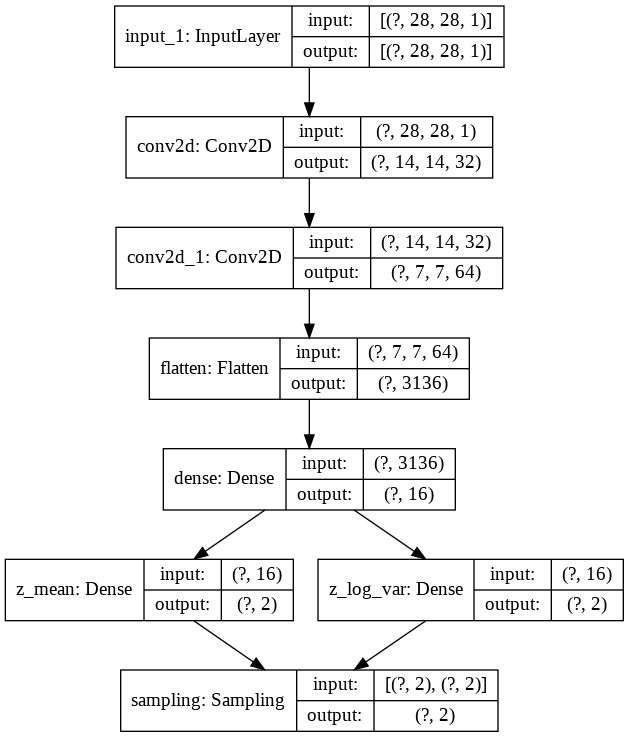

In [7]:
tf.keras.utils.plot_model(encoder, show_shapes=True, show_layer_names=True)

## Decoder

In [8]:
def build_decoder(latent_dims=LATENT_DIM):
  latent_inputs = Input(shape=(latent_dims,))
  x = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
  x = Reshape((7, 7, 64))(x)
  x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
  decoder = Model(latent_inputs, decoder_outputs, name="decoder")
  return decoder

decoder = build_decoder()
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

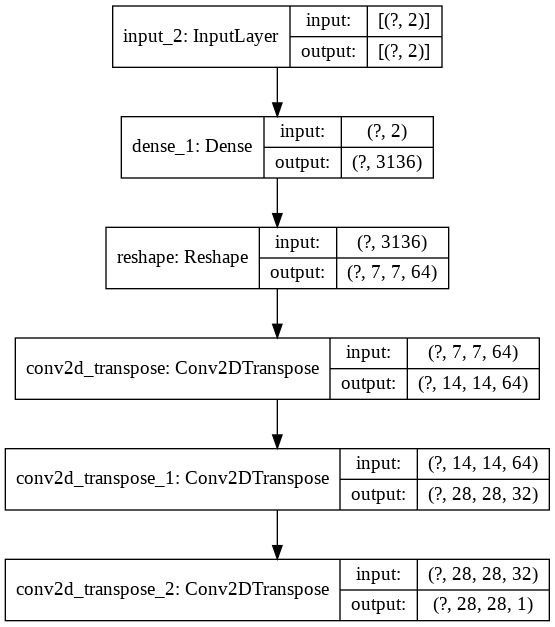

In [9]:
tf.keras.utils.plot_model(decoder, show_shapes=True, show_layer_names=True)

## Model

![](https://i1.wp.com/theailearner.com/wp-content/uploads/2019/09/vae_model.png?resize=625%2C168&ssl=1)

In [10]:
class VAE(Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

  def train_step(self, data):
    if isinstance(data, tuple):
        data   = data[0]
        labels = data[1]
    
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(data, reconstruction)
        )
        reconstruction_loss *= 28 * 28
        
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + kl_loss
    
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    return {
        "loss": total_loss,
        "reconstruction_loss": reconstruction_loss,
        "kl_loss": kl_loss,
    }

## Reconstruction Loss
* Measures how well a reconstructed image compares pixel by pixel to the original
* In this example we measure the average loss

![](https://user-images.githubusercontent.com/37034031/48129147-fb783e00-e2cb-11e8-856c-22b204afa87a.png)


## Kullbeck-Leibler Divergence
* Measures how much one distribution differs from another
* For our VAE we want to measure how much our mu & log_var parameters differ from a normal distribution
* By adding KL Divergence to our loss, we penalize the network for generating a space that is not roughly normal
  * Mean = 0
  * Log Standard Deviation = 0 = log(1)
* Our network then needs to learn:
  * How to reconstruct images
  * How to represent the low level details as normal distributions
* What does it mean to represent as a normal?
  * It needs to efficiently use the space that a normal distribution to separate (in this case) image details

![](https://cdn-ak.f.st-hatena.com/images/fotolife/y/yusuke_ujitoko/20170507/20170507192925.png)

In [11]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

@interact
def kl_example(mean=(-5.0, 5.0, .1), std=(0.0, 3.0, 0.1), show=False):
  x = np.arange(-10, 10, 0.001)
  p = norm.pdf(x, mean, std)
  q = norm.pdf(x, 2, 2)

  plt.figure(figsize=(10, 8))
  plt.title('KL(P||Q) = %1.3f' % kl_divergence(p, q))
  plt.plot(x, p)
  if show == True:  
    plt.plot(x, q)

interactive(children=(FloatSlider(value=0.0, description='mean', max=5.0, min=-5.0), FloatSlider(value=1.5, de…

## Reparameterization
* We need to draw random samples to pass to the decoder
  * Use our estimate of mean and standard deviation (z)
  * Learn by backpropagating error through the network
* But, we can't back propagate through a random number
* So, we use the reparameterization trick

![](https://www.mathworks.com/help/examples/nnet/win64/GeneratingHanddrawnDigitsUsingAVariationalAutoencoderVAEExample_01.png)

## Training


In [12]:
EPOCHS = 30
BATCH_SIZE = 128

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(mnist_digits,
                  mnist_labels,
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE)

Epoch 1/30
547/547 [==============================] - 4s 8ms/step - loss: 211.3645 - reconstruction_loss: 210.0160 - kl_loss: 1.3485
Epoch 2/30
547/547 [==============================] - 4s 7ms/step - loss: 171.1877 - reconstruction_loss: 167.7405 - kl_loss: 3.4472
Epoch 3/30
547/547 [==============================] - 4s 7ms/step - loss: 163.4926 - reconstruction_loss: 159.9968 - kl_loss: 3.4959
Epoch 4/30
547/547 [==============================] - 4s 7ms/step - loss: 160.1771 - reconstruction_loss: 156.6402 - kl_loss: 3.5369
Epoch 5/30
547/547 [==============================] - 4s 8ms/step - loss: 157.8422 - reconstruction_loss: 154.2802 - kl_loss: 3.5620
Epoch 6/30
547/547 [==============================] - 4s 7ms/step - loss: 156.1462 - reconstruction_loss: 152.5633 - kl_loss: 3.5829
Epoch 7/30
547/547 [==============================] - 4s 8ms/step - loss: 154.7481 - reconstruction_loss: 151.1444 - kl_loss: 3.6037
Epoch 8/30
547/547 [==============================] - 4s 7ms/step - l

## Testing
* We're not particularly interested in getting a perfect reconstruction
* We want to learn a low level representation along two gaussians (X & Y)
* Our loss is a combination of reconstruction error and KL Divergence

In [14]:
def plot_performance(history, color_train='blue'):
  fig, ax = plt.subplots(figsize=(12,10))
  
  acc = history.history['loss']
  epochs = range(1, len(acc) + 1)
  ax = plt.subplot(3, 1, 1)
  plt.plot(epochs, acc, 'b', color=color_train, label='Train')
  plt.title('Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  ax.legend()
  
  ax = plt.subplot(3, 1, 2)
  loss = history.history['kl_loss']
  epochs = range(1, len(loss) + 1)    
  plt.plot(epochs, loss, 'b', color=color_train, label='Train')
  plt.xlabel('Epochs')
  plt.ylabel('KL Loss')
  plt.legend()

  ax = plt.subplot(3, 1, 3)
  loss = history.history['reconstruction_loss']
  epochs = range(1, len(loss) + 1)    
  plt.plot(epochs, loss, 'b', color=color_train, label='Train')
  plt.xlabel('Epochs')
  plt.ylabel('Reconstruction Loss')
  plt.legend()

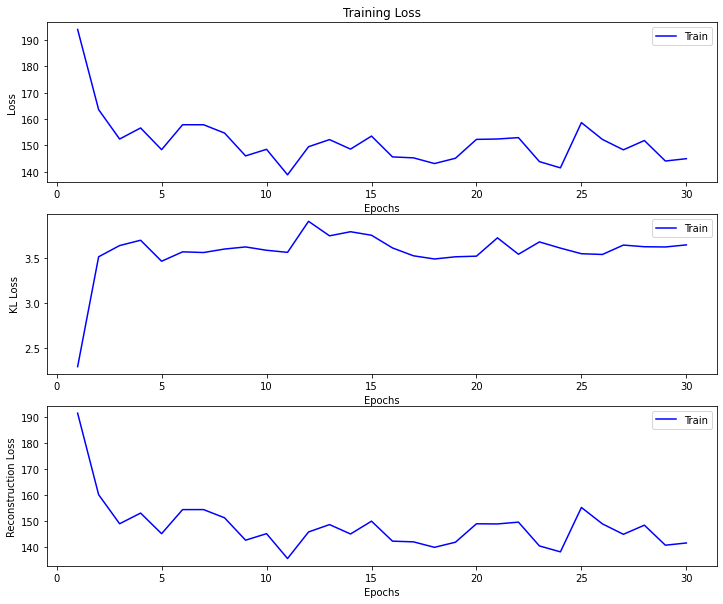

In [15]:
plot_performance(history)

## Latent Plot

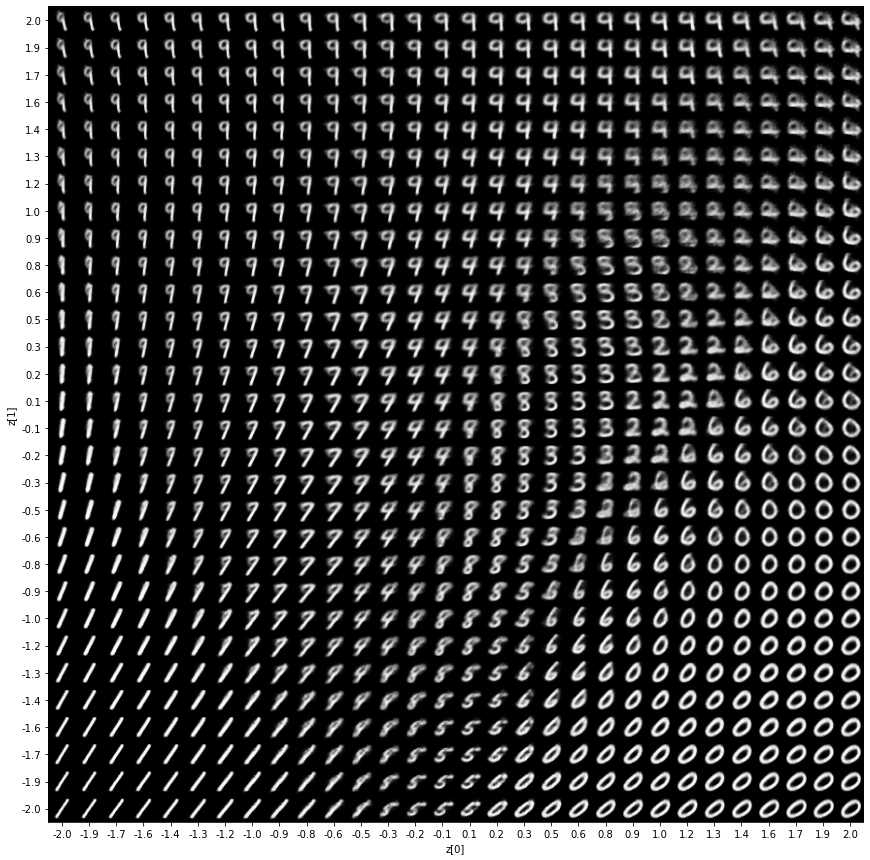

In [16]:
def plot_latent(encoder, decoder):
  # display a n*n 2D manifold of digits
  n = 30
  digit_size = 28
  scale = 2.0
  figsize = 15
  figure = np.zeros((digit_size * n, digit_size * n))
  # linearly spaced coordinates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace(-scale, scale, n)
  grid_y = np.linspace(-scale, scale, n)[::-1]

  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(digit_size, digit_size)
          figure[
              i * digit_size : (i + 1) * digit_size,
              j * digit_size : (j + 1) * digit_size,
          ] = digit

  plt.figure(figsize=(figsize, figsize))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range + 1
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, cmap="Greys_r")
  plt.show()

plot_latent(encoder, decoder)

## Latent Space

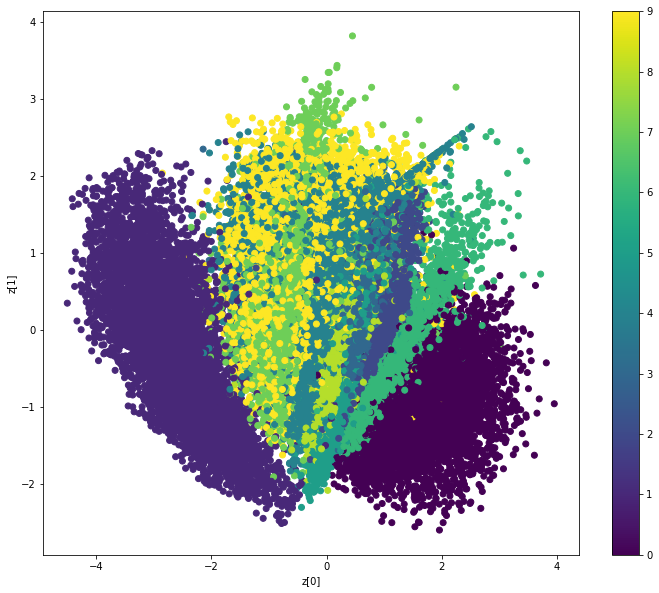

In [17]:
def plot_label_clusters(encoder, decoder, data, labels):
  z_mean, _, _ = encoder.predict(data)
  plt.figure(figsize=(12, 10))
  plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
  plt.colorbar()
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.show()

(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)

## Generate Image

In [18]:
@interact
def generate_image(x_latent=(-5.0, 5.0, 0.1), y_latent=(-5.0, 5.0, 0.1)):
  z_sample = np.array([[x_latent, y_latent]])
  x_decoded = decoder.predict(z_sample)
  digit = x_decoded[0].reshape(28, 28)
  plt.imshow(digit, cmap="Greys_r")
  plt.show()

interactive(children=(FloatSlider(value=0.0, description='x_latent', max=5.0, min=-5.0), FloatSlider(value=0.0…

# Closing
* VAEs are an important stop on the road to generative deep learning
* They were state of the art not too long ago
* They've been eclipsed by generative adversarial networks (GAN) which brings
  * Style transfer
  * Music generation
  * Deep fakes
  * Snapchat Filters
* In NLP the decoder / encoder networks help with:
  * Question & Answer
  * Text summarization
  * Text generation